## Import packages

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import keras
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import datasets, model_selection
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data preparation

In [ ]:
classes = ['diijam', 'baomoi', 'fptplay', 'iQIYI', 'bigo', 'myradio', 'spotify', 'nhaccuatui', 'soundcloud', 'sachnoiapp', 'phim247', 'popskid',
           'truyenaudiosachnoiviet', 'vieon', 'voizfm', 'tunefm', 'wetv', 'zingmp3', 'truyenaudio', 'baohay24h', 'freefire', 'among_us', 'azar', 'comico', 'nimotv',
           'mangatoon', 'medoctruyen', 'nhacvang', 'noveltoon', 'radiofm', 'tivi247', 'vtvgo', 'tivi24h', 'tinder', 'tinmoi24h', 'tivi360',
           'tiktok', 'linkedin', 'tiki', 'tinhte', 'lotus', 'tivi_truyentranh_webtoon', 'tuoitre_online', 'vietnamworks', 'wallstreet_journal', 'cnn_news', 'bbc_news',
           'twitter', 'weeboo', 'twitch', 'vnexpress', 'topcv', 'toc_chien', 'wesing', 'hago', 'google_meet', 'dubsmash', 'facebook',
           'hahalolo', 'zalo', 'hello_yo', 'dan_tri', 'zoom', 'wikipedia', 'instagram', 'jobway', 'kaka', 'pinterest', 'quora', 'lazada', 'chess', 'cake', 'mobile_legend', 'co_tuong_online',
           'ted', 'telegram', 'starmarker', 'skype', 'soha', 'tango', 'thanhnien', 'snapchat', 'tien_len', 'animal_restaurant', 'bida', 'cho_tot', 'messenger', 'netflix', 'nonolive', 'may',
           'podcast_player', 'pubg', 'partying', 'kenh14', 'lienquan_mobile', 'likee_lite', 'reddit', 'sendo', 'shopee', 'the_guardian', 'ola_party']

k = 30

In [ ]:
train_graphs_folder = '/content/drive/My Drive/AI PROJECTS/GNN/dataset/5_3/stand_train_graphs/N30/t10'
test_graphs_folder = '/content/drive/My Drive/AI PROJECTS/GNN/dataset/5_3/stand_test_graphs/N30/t10'

In [ ]:
def graphs_one_app(app, graphs_folder):
  X = []

  app_graph_folder = os.path.join(graphs_folder, app)
  features_path = os.path.join(app_graph_folder, 'features.csv')
  weights_path = os.path.join(app_graph_folder, 'weights.csv')

  features_df = pd.read_csv(features_path, index_col=0)
  weights_df = pd.read_csv(weights_path, index_col=0)

  graph_num = features_df['graph_id'].iloc[-1]

  for i in range(1, graph_num+1):
    feature_df = features_df[features_df['graph_id'] == i]
    feature_df = feature_df.set_index('IP_port')
    
    # drop graph_id column
    feature_df = feature_df.drop(['graph_id'], axis=1)
    feature_df = feature_df.iloc[:k]

    if feature_df.shape[0] > 0:
      features = feature_df.values
      padding = np.zeros([k - features.shape[0], features.shape[1]])
      features = np.concatenate((features, padding), axis=0)
      features = features.flatten().tolist()
      X.append(features)

    if i >= 100 and i % 100 == 0:
      print('Graph: ', i)
  
  labels = [app]*graph_num
    
  return X, labels

In [ ]:
def generate_graphs(graphs_folder):
  # build a list of graphs and labels: note that only apply for more than 2 classes
  X = []
  labels = []
  idx = 0

  for app in classes:
    idx += 1
    print('Loading {} ... {}/{}'.format(app, idx, len(classes)))
    
    one_app_X, one_app_labels = graphs_one_app(app, graphs_folder)
    X.extend(one_app_X)
    labels.extend(one_app_labels)
    

  return X, labels

In [ ]:
X_train, train_labels = generate_graphs(train_graphs_folder)
X_test, test_labels = generate_graphs(test_graphs_folder)

Loading diijam ... 1/101
Graph:  100
Graph:  200
Graph:  300
Loading baomoi ... 2/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Loading fptplay ... 3/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Loading iQIYI ... 4/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Loading bigo ... 5/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Graph:  900
Loading myradio ... 6/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Loading spotify ... 7/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Loading nhaccuatui ... 8/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Graph:  900
Graph:  1000
Graph:  1100
Graph:  1200
Loading soundcloud ... 9/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Loading sachnoiapp .

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = train_labels
y_test = test_labels

In [ ]:
X_train.shape

(66236, 1890)

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_dummy = encoder.transform(y_train)
y_test_dummy = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)
y_train_dummy = np_utils.to_categorical(y_train_dummy)
y_test_dummy = np_utils.to_categorical(y_test_dummy)

In [ ]:
y_train_dummy.shape

(66236, 101)

----------

## Build classification models

Fully connected Neural Network

In [ ]:
batch_size = 128

In [ ]:
# define baseline model
def baseline_model(features_num, classes_num):
  # create model
  model = Sequential()
  model.add(Dense(1024, input_dim=features_num, activation='relu'))
  model.add(BatchNormalization())

  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())
  
  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())

  model.add(Dense(classes_num, activation='softmax'))
  
  decay_epoch = 10
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=(X_train.shape[0]//batch_size)*decay_epoch,
    decay_rate=0.9)
  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
  
  model.compile(
    optimizer=optimizer, loss=categorical_crossentropy, metrics=["acc"],
  )
  
  return model

In [ ]:
X_train

array([[ 0.76129481,  0.4865941 ,  2.44447215, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76129481,  0.4865941 ,  2.12245506, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76129481,  0.4865941 ,  2.11192554, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.06444538,  0.29513923,  0.64241123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05071166,  0.29513923,  0.10901539, ...,  0.89019608,
         0.1254902 ,  0.53333333],
       [ 0.76129481, -0.66213513,  1.76191661, ...,  0.45882353,
         0.01568627,  0.9372549 ]])

In [ ]:
model = baseline_model(63*k, len(classes))

history = model.fit(X_train, y_train_dummy, epochs=120, batch_size=128, validation_data=(X_test, y_test_dummy))

Epoch 1/120
518/518 [==============================] - 26s 12ms/step - loss: 4.4226 - acc: 0.1128 - val_loss: 2.6675 - val_acc: 0.4008
Epoch 2/120
518/518 [==============================] - 6s 11ms/step - loss: 2.3958 - acc: 0.4541 - val_loss: 1.9962 - val_acc: 0.5367
Epoch 3/120
518/518 [==============================] - 5s 11ms/step - loss: 1.8022 - acc: 0.5805 - val_loss: 1.6597 - val_acc: 0.6107
Epoch 4/120
518/518 [==============================] - 5s 10ms/step - loss: 1.4593 - acc: 0.6596 - val_loss: 1.4427 - val_acc: 0.6568
Epoch 5/120
518/518 [==============================] - 5s 10ms/step - loss: 1.2396 - acc: 0.7107 - val_loss: 1.2845 - val_acc: 0.6914
Epoch 6/120
518/518 [==============================] - 5s 10ms/step - loss: 1.0605 - acc: 0.7522 - val_loss: 1.1633 - val_acc: 0.7201
Epoch 7/120
518/518 [==============================] - 5s 10ms/step - loss: 0.9170 - acc: 0.7890 - val_loss: 1.0666 - val_acc: 0.7419
Epoch 8/120
518/518 [==============================] - 5s 10m

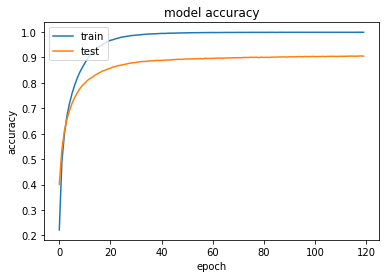

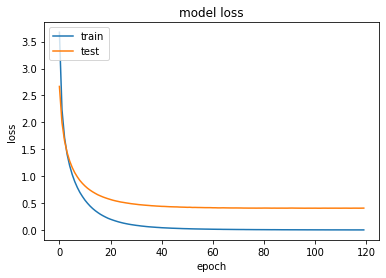

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred

pred_labels = np.argmax(y_pred, axis=-1) 
pred_labels = encoder.inverse_transform(pred_labels)


print(classification_report(y_test, pred_labels, digits=4))

                          precision    recall  f1-score   support

                among_us     0.9653    0.8742    0.9175       159
       animal_restaurant     0.8140    0.7955    0.8046       132
                    azar     0.9355    0.9667    0.9508       180
               baohay24h     0.8485    0.9272    0.8861       151
                  baomoi     0.8974    0.9091    0.9032       154
                bbc_news     0.8108    0.8276    0.8191       145
                    bida     0.9887    0.9887    0.9887       177
                    bigo     0.9919    0.9839    0.9879       248
                    cake     0.9364    0.9586    0.9474       169
                   chess     0.8701    0.8800    0.8750       175
                 cho_tot     0.9396    0.9344    0.9370       183
                cnn_news     0.8633    0.8511    0.8571       141
         co_tuong_online     0.7407    0.7246    0.7326       138
                  comico     0.8299    0.8846    0.8564       182
         

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=200, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# overall accuracy
acc = rf_model.score(X_test,y_test)
acc

In [ ]:
y_pred = rf_model.predict(X_test)

# pred_labels = np.argmax(y_pred, axis=-1) 
# pred_labels = encoder.inverse_transform(pred_labels)


print(classification_report(y_test, y_pred, digits=4))

                          precision    recall  f1-score   support

                among_us     1.0000    0.9119    0.9539       159
       animal_restaurant     0.8333    0.9091    0.8696       132
                    azar     1.0000    0.9889    0.9944       180
               baohay24h     0.8922    0.9868    0.9371       151
                  baomoi     0.9375    0.9740    0.9554       154
                bbc_news     0.8782    0.9448    0.9103       145
                    bida     1.0000    0.9887    0.9943       177
                    bigo     1.0000    0.9879    0.9939       248
                    cake     0.9061    0.9704    0.9371       169
                   chess     0.9883    0.9657    0.9769       175
                 cho_tot     1.0000    0.9945    0.9973       183
                cnn_news     0.8535    0.9504    0.8993       141
         co_tuong_online     0.8345    0.8768    0.8551       138
                  comico     0.9027    0.9176    0.9101       182
         

XGBoosting

In [ ]:
X_train.shape

(66236, 630)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg_model = XGBClassifier()
xg_model.fit(X_train, y_train)

# make predictions for test data
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]

# evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# overall accuracy
acc = xg_model.score(X_test, y_test)
acc

0.9686009298955377